## Building a Custom Visualization

---

When it comes to visualizing data, challenges arise when users are faces with trying to make judgements about probabilistic data generated through samples.

A challenge that users face is that, for a given y-axis value (e.g. 42,000), it is difficult to know which x-axis values are most likely to be representative, because the confidence levels overlap and their distributions are different (the lengths of the confidence interval bars are unequal). One of the solutions proposed for this problem is to allow users to indicate the y-axis value of interest (e.g. 42,000) and then draw a horizontal line and color bars based on this value. So bars might be colored red if they are definitely above this value (given the confidence interval), blue if they are definitely below this value, or white if they contain this value. Even more nuanced- bars can change colors based on a gradient from red to blue, with white included only when the indicated y-axis value is exactly equal to the estimated parameter value from a given sample.


I've chosen to add interactivity to the above with a gradient response, which allows the user to click within the plot in order to set a y-axis value of interest; the bar colors change along a gradient from red to blue with respect to what value the user has selected.

Indicated y-axis value was transformed into a ratio given the error bar (estimated standard error) max and min values ((y - low)/ (high- low)); ratio values were then binned across 10 equal intervals ranging from .09 to 1. Therefore, bar color changes are reflective of the mapping between these intervals and a generated 10 element color gradient (r,g,b) list, with white existing only when the ratio = 0.5 (i.e., indicated y-axis value is exactly equal to estimated parameter value for given sample).

<IPython.core.display.Javascript object>


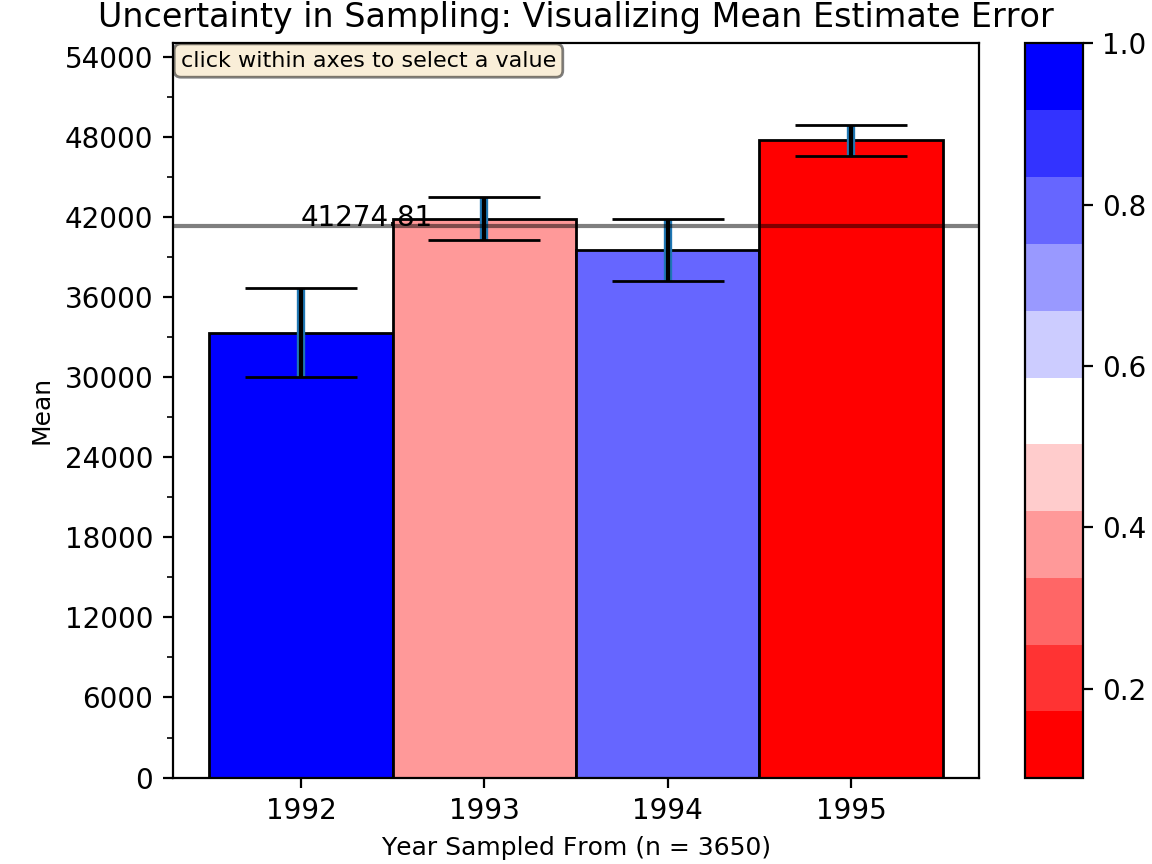

In [4]:
# Use the following data for this assignment:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib as mtl
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import CheckButtons


class PointPicker(object):
    def __init__(self, fig, ax, df_mean, df_std_err, clicklim=0.05):
        self.fig = fig
        #self.fig = ax.figure
        self.ax = ax
        
        self.bars = ax.bar(df_mean.index, df_mean, width = 1, yerr = df_std_err, label = 'bars', edgecolor = 'black', tick_label = df_mean.index)
        self.ax.set_title('Uncertainty in Sampling: Visualizing Mean Estimate Error')
        self.ax.set_xlabel("Year Sampled From (n = 3650)", fontsize = 9)
        self.ax.set_ylabel("Mean", fontsize = 9)
        mtl.rcParams.update({'font.size': 10})
        #self.ax.margins(x=.15)
        # place a text box in upper left in axes coords
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        self.ax.text(0.01, 0.99, 'click within axes to select a value', transform=self.ax.transAxes, fontsize=8,
        verticalalignment='top', bbox = props)
        
        #fig.show()
        
        # Create the colormap
        #cm = LinearSegmentedColormap.from_list('custom', colors = colors, N = 10)
        #data = [[1, 1], [1, 1]]
        # Fewer bins will result in "coarser" colomap interpolation
        #im = self.ax.imshow(data, interpolation='nearest', origin='lower', cmap=cm)
        

        #self.fig.colorbar(im)

        
        self.colors = colors
        self.proportions = np.linspace(0.09, 1, 10) #range of 10 values from .09 to 1
        self.horizontal_line = ax.axhline(y=.5, color='black', alpha=0.5)
        self.text = ax.text(0,0.5, "")
        self.fig.canvas.mpl_connect('button_press_event', self.onclick)
              
              
        lc = [i for i in self.bars.errorbar.get_children() if i is not None][0]
        error_bar_list = []
        for y_err in lc.get_segments():
            high_error_limit = y_err[1,1]
            low_error_limit = y_err[0,1]
            error_bar_list.append((low_error_limit, high_error_limit))
        #print(f"error bar list of outer, inner ranges:{error_bar_list} is equal to standard error values:{std_err}") 
        self.errors = error_bar_list

    def onclick(self, event):
        if event.inaxes == self.ax:
            x = event.xdata
            y = event.ydata
            xlim0, xlim1 = ax.get_xlim()
            y_formatted = format(y, '.2f')
            self.horizontal_line.set_ydata(y)
            self.text.set_text(str(y_formatted))
            self.text.set_position((1992, y))
            #self.ax.set_title('Y-data value is {} \n and X-data value is {}'.format(y, x))
            transformed_y_values = [(y - low)/ (high- low) for low, high in self.errors]
            for y_index, transformed_y in enumerate(transformed_y_values):
                if transformed_y > self.proportions[9]:
                    #color = self.colors[p_index] #links proportion to color via its index
                    self.bars[y_index].set_color('blue') # links bar number to its y_transformed
                    self.bars[y_index].set_edgecolor('black')                  
                for p_index, proportion in enumerate(self.proportions):
                    if transformed_y <= proportion:
                        color = self.colors[p_index] #links proportion to color via its index
                        self.bars[y_index].set_color(color) # links bar number to its y_transformed
                        self.bars[y_index].set_edgecolor('black')
                        break                  
                
            self.fig.canvas.draw()      


np.random.seed(12345)

df = pd.DataFrame([np.random.normal(32000,200000,3650), 
                   np.random.normal(43000,100000,3650), 
                   np.random.normal(43500,140000,3650), 
                   np.random.normal(48000,70000,3650)], 
                  index=[1992,1993,1994,1995])
#Consider making boxplots of sample distributions here. Maybe even animation of histograms for each

df_mean = df.mean(axis=1)
std_err = df.std(axis=1)/((len(df.columns))**(1/2))
#print(type(df_mean))
#print(std_err)
#print(f"means:{df_mean}")
#print(f"means describe:{df_mean.describe()}")
#print(f"upper bound check- df_mean[i]:{df_mean[1992]} + (error/2):{std_err.iloc[0]/2} is :{df_mean[1992] + (std_err.iloc[0]/2)} ")
error_list = []
i =0
#print(df_std_err)
for error in std_err:
    #print(f"std_error Value {i}:{error}")
    upper_half = df_mean.iloc[i] + (error/2)
    lower_half = df_mean.iloc[i] - (error/2)
    error_list.append((upper_half, df_mean.iloc[i], lower_half))
    i+=1

#Build color gradient as range of ten possible (r,g,b) values
base = list(range(0, 255, 51))
full = [255] * 6
blue1 = np.array(base + full)
blue = blue1/255
base.reverse()
red = np.array(full + base)
red = red/255
tail = base[:]
base.reverse()
green = np.array(base + [255] + tail)/255
global colors
colors = np.array([red, green, blue]).T #From Red to Blue spectrum (r,g,b) as index increases
#print(f'Base {base} \n full: {full}\n blue1:{blue1} \n blue; {blue} \n red: {red} \n tail: {tail} \n green: {green} \n colors: {colors}'    
    
fig  = plt.figure(figsize = (5.76, 4.32))
size = fig.get_size_inches()
ax1  = fig.add_axes([0.15,0.10,0.70,0.85])
#print(size)
ax2  = fig.add_axes([0.89,0.10,0.05,0.85])

        
#fig, ax2 = plt.subplots(figsize=(6, 1))
#fig.subplots_adjust(bottom=0.5)
#np.linspace(0.09, 1, 10)
cmap = mtl.colors.ListedColormap(colors)
cmap.set_over('0.25')
cmap.set_under('0.75')
norm = mtl.colors.Normalize(vmin=.09,vmax=1)
cb1  = mtl.colorbar.ColorbarBase(ax2,cmap=cmap,norm=norm,orientation='vertical')

#bounds = [1, 2, 4, 7, 8]
#norm = mtl.colors.BoundaryNorm(bounds, cmap.N)
#cb2 = mtl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm,boundaries=[0] + bounds + [13], extend='both', ticks=bounds, spacing='proportional', orientation='horizontal')
#cb2.set_label('Discrete intervals, some other units')
        
#fig, ax1 = plt.subplots()
#ax1 = fig.gca()
#ax1 = fig.add_subplot(1,1,1)
#bars = ax1.bar(df_mean.index, df_mean, width = 1, yerr = df_std_err, label = 'bars', edgecolor = 'black', tick_label = df_mean.index )
ax1.set_ylim(0,55000)
#Specify major and minor y-tick numbers
yticks = ticker.MaxNLocator(10)
y_minorticks = ticker.MaxNLocator(21)
ax1.yaxis.set_major_locator(yticks)
ax1.yaxis.set_minor_locator(y_minorticks)

#ax1.errorbar(df_mean.index, df_mean, df_std_err, fmt = 'none', solid_capstyle = 'projecting', markersize=8, capsize=50)
(_, caplines, _) = ax1.errorbar(df_mean.index, df_mean, std_err, fmt = 'none', capsize=20, elinewidth=3, label = 'errorbar')
for cap in caplines:
    cap.set_color('black')
    cap.set_markeredgewidth(1)
#print(f"errorbar container artists are {bars.errorbar.get_children()}")    
#lc = [i for i in bars.errorbar.get_children() if i is not None][0]
#print('checktest:'.format(ax1.get_children()))


#fig = plt.figure()
#fig.set_figheight(1)
#fig.set_figwidth(1)
#ax = fig.add_subplot(111)
p = PointPicker(fig, ax1, df_mean, std_err)
#plt.close()
#fig.subplots_adjust=0.85
#plt.tight_layout()
fig.show()
#plt.show()
#print(f"mean values descriptives: {df_mean.describe()}")

#print(coords3)

<IPython.core.display.Javascript object>


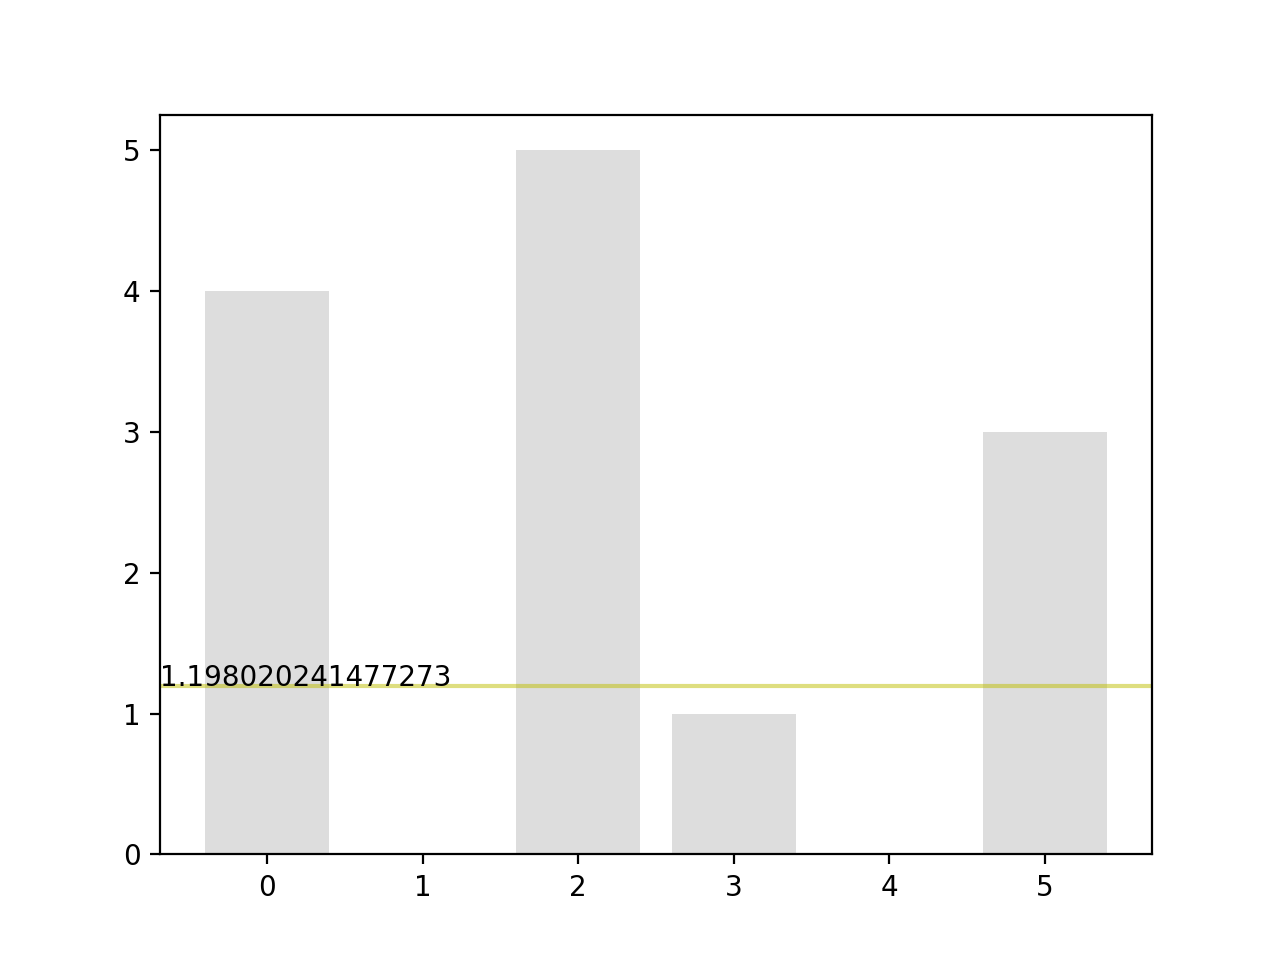

In [3]:
#Example event listener and event generator in Class PointPickers
import matplotlib.pyplot as plt

class PointPickers(object):
    def __init__(self, ax, clicklim=0.05):
        self.fig=ax.figure
        self.ax = ax
        self.clicklim = clicklim
        self.horizontal_line = ax.axhline(y=.5, color='y', alpha=0.5)
        self.text = ax.text(0,0.5, "")
        #print(self.horizontal_line)
        self.fig.canvas.mpl_connect('button_press_event', self.onclick)


    def onclick(self, event):
        if event.inaxes == self.ax:
            x = event.xdata
            y = event.ydata
            xlim0, xlim1 = ax.get_xlim()
            if x <= xlim0+(xlim1-xlim0)*self.clicklim:
                self.horizontal_line.set_ydata(y)
                self.text.set_text(str(y))
                self.text.set_position((xlim0, y))
                self.fig.canvas.draw()


if __name__ == '__main__':

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar([0,2,3,5],[4,5,1,3], color="#dddddd")
    p = PointPickers(ax)
    plt.show()